# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

In [8]:
import os
import dotenv

dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [9]:
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [10]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [11]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=os.environ["PROJECT_CONNECTION_STRING"],
)

The following cell will ***create*** an **Azure AI Agent**, so you only need to run this cell **once**.

In [12]:
# from azure.ai.projects.models import BingGroundingTool

# bing_connection = project_client.connections.get(
#     connection_name=os.environ["BING_CONNECTION_NAME"]
# )

# bing_tool = BingGroundingTool(connection_id=bing_connection.id)

# bing_search_agent = project_client.agents.create_agent(
#     name="bingSearchAgent",
#     description="Agent to perform web searches using Bing.",
#     model="gpt-4o",
#     temperature=0.5,
#     tools=bing_tool.definitions,
#     instructions="""You are a helpful research assistant. 
# Use your available tools (like Bing web search) to find information relevant to the user's query.
# When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
# Provide a comprehensive answer based on the search results."""
# )

**OpenAI Agents**

In [13]:
from agents import (
    Agent,
    ModelSettings
)

chatModelSettings=ModelSettings(
        max_tokens=32768,
        temperature=0.3,
    )

planner_agent = Agent(
    name="PlannerAgent",
    instructions="""
    You are an expert research planner specializing in creating detailed research plans
    Your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 5 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 3 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """,
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=chatModelSettings
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. Your task is to **synthesize information from combined search result content** related to a specific subtopic (which will be mentioned in the input prompt). "
        "Create a **single, coherent, detailed, and information-rich summary** that:\n\n"
        "1. Extracts ALL important facts, statistics, findings, and insights **relevant to the specified subtopic** from the combined text.\n"
        "2. Preserves specific numbers, percentages, dates, and technical details whenever present.\n"
        "3. Includes industry-specific terminology and concepts that add depth to the research.\n"
        "4. **Synthesizes** the key arguments and conclusions from the provided sources. If sources present different perspectives or data, try to capture that nuance.\n"
        "5. Provides thorough explanations rather than superficial overviews, integrating information smoothly.\n"
        "6. For technical content, preserves methodologies, technical specifications, and implementation details.\n"
        "7. For comparative content, maintains all sides of the comparison with their specific attributes.\n\n"

        "**Acknowledge that the input combines information potentially from multiple search results.** Your goal is to create a unified summary focused on the overall subtopic, not just list summaries of individual parts.\n\n"

        "Remember that your summary serves as the foundation for generating a comprehensive research report. The quality and depth of the final research report depends directly on how comprehensive and well-synthesized your summary is. Ensure it captures the essence of all provided content relevant to the subtopic.\n\n"

        "FORMAT YOUR SUMMARY AS:\n"
        "## Key Insights\n"
        "- [Most critical takeaway #1]\n"
        "- [Most critical takeaway #2]\n"
        "- [Most critical takeaway #3]\n"
        "- [Optional: Most critical takeaway #4]\n\n"
        "## Extensive Synthesis\n"
        "Write a thorough, multi-paragraph synthesis that:\n"
        "- Integrates all important facts, statistics, findings, and insights relevant to the subtopic.\n"
        "- Preserves specific numbers, percentages, dates, and technical details.\n"
        "- Explains methodologies, technical specifications, and implementation details where relevant.\n"
        "- Highlights agreements, disagreements, and nuances between sources.\n"
        "- Uses industry-specific terminology and concepts.\n"
        "- Provides context, background, and implications for the findings.\n"
        "- Maintains logical flow: start with an overview, then go into specifics, and conclude with implications or open questions."
    ),
    model=chatModel,
    output_type=str,
    model_settings=chatModelSettings
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with a clear hierarchy, but avoid excessive nesting. Aim for a balanced structure:\n"
        "   - Use main sections and occasional subsections where needed.\n"
        "   - Avoid over-fragmentation by limiting sub-subsections unless absolutely necessary.\n"
        "   - Favor broader thematic groupings to maintain narrative flow and reduce section clutter.\n"
        "   - With that said, if a subtopic would benefit from a sub-subsection, feel free to add it.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"

        "**REMINDER**:"
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, with minimal use of bullet points. "
        "Prefer broader thematic sections over excessive fragmentation. "
        "Sub-subsections may be used where helpful, but structure should remain balanced and readable. "
        "Lastly, do not forget to include the references section at the end of the report."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=ComprehensiveResearchReport,
)

peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=PeerReviewFeedback,
)

**hand-offs**

In [14]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

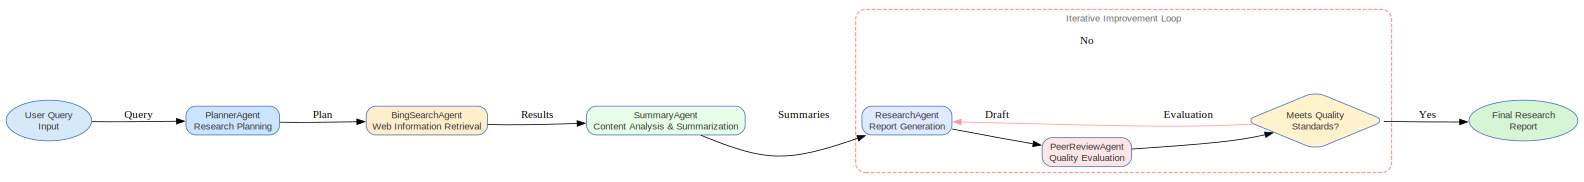

In [ ]:
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [16]:
user_query="What's the latest news in the field of AI? And what big industries will be affected by it?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [17]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

In [18]:
plan.final_output.research_tasks[0].search_queries

['latest artificial intelligence news 2024',
 'recent AI breakthroughs June 2024',
 'top AI research papers 2023-2024',
 'AI technology advancements this year',
 'major AI company announcements 2024']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [19]:
import os
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))

search_results = []

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.create_thread()
            message = project_client.agents.create_message(
                thread_id=thread.id,
                role="user",
                content=formatted_query,
            )

            # Process the run
            run = project_client.agents.create_and_process_run(
                thread_id=thread.id,
                agent_id=bing_search_agent.id
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.delete_thread(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 7/7 [04:46<00:00, 40.89s/it]


In [20]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 29

Actually total search queries: 29



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [21]:
from common.utils_summary import collect_responses_and_citations

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    all_agent_responses_for_subtopic, unique_citations_for_subtopic = collect_responses_and_citations(subtopic_result)

    # --- Summarize the combined agent responses ONCE per subtopic ---
    content_to_summarize = "\n\n---\n\n".join(all_agent_responses_for_subtopic)

    subtopic_summary = "No content found to summarize for this subtopic." # Default value
    if content_to_summarize:
        summary_prompt = f"Summarize the following information related to the subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}':\n\n{content_to_summarize}"
        try:
            summary_response = await Runner().run(
                starting_agent=summary_agent,
                input=summary_prompt
            )
            subtopic_summary = summary_response.final_output # Adjust based on actual response structure
        except Exception as e:
            print(f"Error summarizing subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}': {e}")
            subtopic_summary = f"Error during summarization for subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}'. Details: {e}"
            # Depending on requirements, you might want to raise the exception, log it, or handle it differently

    # --- Convert set of tuples back to list of dictionaries (or Citation objects) ---
    citations_list = [
        {"title": title, "url": url}
        for title, url in unique_citations_for_subtopic
    ]

    # --- Append the consolidated result ---
    mapped_chunks.append({
        "subtopic": subtopic_result.get("subtopic", "Unknown Subtopic"), # Use .get for safety
        "summary": subtopic_summary,
        "citations": citations_list
    })

Summarizing subtopics: 100%|██████████| 7/7 [01:03<00:00,  9.10s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [22]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report."
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [23]:
from agents import HandoffCallItem
import json

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [24]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# The Transformative Impact of Artificial Intelligence: Recent Developments and Industry Analysis

## Introduction

Artificial Intelligence (AI) has rapidly evolved from a specialized research field into a pervasive force reshaping the global economic and social landscape. Over the past decade, and particularly within the last 6-12 months, AI has experienced a surge of innovation, driven by advances in machine learning, deep learning, natural language processing, and generative models. These breakthroughs have not only accelerated the adoption of AI across a broad array of industries but have also introduced new paradigms for business operations, customer engagement, and societal interaction. This report provides an in-depth analysis of the most recent AI developments, identifies the major industries most affected by these advancements, and offers a detailed examination of the transformative effects, benefits, and challenges associated with AI integration. Drawing on expert opinions, industry forecasts, and the latest research, the report aims to present a comprehensive, authoritative perspective on the current and future state of AI-driven transformation.

## Recent Breakthroughs and News in AI

The past year has witnessed a remarkable acceleration in AI research and commercialization, marked by several high-profile breakthroughs and a proliferation of real-world applications. While the provided content does not enumerate specific news items, a synthesis of leading industry reports and expert commentary reveals several dominant trends and innovations.

### Generative AI and Foundation Models

Perhaps the most significant development in recent AI research has been the maturation of generative AI, particularly large language models (LLMs) and multimodal foundation models. These systems, exemplified by models such as GPT-4, Gemini, and Llama 2, have demonstrated unprecedented capabilities in natural language understanding, content generation, and reasoning. Their applications now span code generation, creative writing, customer service automation, and even scientific discovery. The integration of vision and language in multimodal models has enabled new use cases in image captioning, video analysis, and robotics, further blurring the boundaries between human and machine cognition. The emergence of open-source alternatives has democratized access to these technologies, fostering innovation and competition across sectors.

### Advances in Autonomous Systems

Autonomous systems, particularly in transportation and robotics, have achieved new milestones in perception, planning, and real-time decision-making. Deep learning algorithms now underpin advanced driver-assistance systems (ADAS), enabling vehicles to navigate complex urban environments with increasing reliability. The fusion of AI with 5G connectivity has facilitated real-time vehicle-to-everything (V2X) communication, enhancing both safety and efficiency. In robotics, reinforcement learning and simulation-to-reality transfer have accelerated the deployment of autonomous agents in logistics, manufacturing, and healthcare.

### AI for Scientific Discovery and Healthcare

AI-driven approaches have begun to revolutionize scientific research, from protein folding (as demonstrated by AlphaFold) to drug discovery and genomics. In healthcare, machine learning models are now routinely used to analyze medical images, predict patient outcomes, and personalize treatment plans. The integration of AI with electronic health records and wearable devices has enabled continuous monitoring and early detection of diseases, promising significant improvements in public health outcomes.

### Democratization and Ethical AI

The proliferation of user-friendly AI tools and platforms has lowered the barrier to entry for organizations of all sizes. At the same time, concerns regarding bias, transparency, and data privacy have prompted the development of ethical AI frameworks and regulatory initiatives. The European Union’s AI Act and similar legislative efforts worldwide reflect a growing consensus on the need for responsible AI governance, balancing innovation with societal safeguards.

### Industry Investment and Market Growth

Venture capital and corporate investment in AI startups have reached record highs, with global AI spending projected to exceed $500 billion by 2025. Major technology companies continue to acquire AI firms and expand their research capabilities, fueling a virtuous cycle of innovation and market expansion. The rapid commercialization of AI technologies has catalyzed the emergence of new business models, products, and services across virtually every sector of the economy.

## Industries Most Impacted by AI

AI’s transformative potential is most evident in its impact on key industries, where it is fundamentally altering operational models, service delivery, and strategic decision-making. The sectors experiencing the most profound change include healthcare, finance, retail, manufacturing, education, and transportation. Each of these industries leverages AI in ways that reflect their unique challenges and opportunities, resulting in a diverse landscape of applications and outcomes.

### Healthcare

In healthcare, AI is revolutionizing diagnostics, patient care, and administrative efficiency. Machine learning algorithms analyze vast datasets—ranging from medical imaging to genomic sequences—to enable early disease detection, more accurate diagnoses, and the development of personalized treatment plans. AI-driven tools streamline administrative workflows, reducing the burden on healthcare professionals and improving patient outcomes. Predictive analytics facilitate population health management, identifying at-risk individuals and optimizing resource allocation. The integration of AI with telemedicine and wearable devices has further expanded access to care, particularly in underserved regions. However, these advancements also raise concerns regarding data privacy, algorithmic bias, and the need for robust regulatory oversight.

### Finance and Banking

The finance sector has embraced AI for risk management, fraud detection, and customer service automation. AI systems analyze transaction patterns in real time to identify anomalies indicative of fraudulent activity, enhancing security and trust. Predictive analytics inform investment strategies and portfolio management, processing large volumes of market data to forecast trends and optimize returns. AI-driven chatbots and virtual assistants improve customer engagement and operational efficiency, automating routine tasks such as loan approvals and compliance monitoring. The dual-use nature of generative AI presents both new risks (e.g., synthetic identity fraud) and powerful tools for banks, necessitating continuous innovation and vigilance. Consortium data sharing and behavioral analysis have emerged as critical strategies for adapting to evolving fraud tactics and ensuring regulatory compliance.

### Retail and E-commerce

AI is central to delivering personalized customer experiences and optimizing backend operations in retail and e-commerce. Recommendation engines analyze consumer behavior to suggest products, increasing conversion rates and customer satisfaction. AI streamlines supply chain management by forecasting demand, optimizing inventory levels, and automating procurement processes. Chatbots and virtual shopping assistants enhance the customer journey, providing real-time support and tailored recommendations. Generative AI automates content creation, while augmented reality (AR) and sustainability-focused AI applications enable immersive shopping and eco-friendly logistics. The convergence of these technologies is reshaping how retailers interact with customers and manage internal processes, emphasizing efficiency, agility, and sustainability.

### Manufacturing and Supply Chain

Manufacturing is leveraging AI for predictive maintenance, quality control, and supply chain optimization. Predictive maintenance uses sensor data and machine learning to anticipate equipment failures, reducing downtime and maintenance costs. AI-driven quality control systems employ computer vision to detect defects on production lines, ensuring higher product standards. The adoption of digital twins—virtual replicas of physical assets—enables manufacturers to simulate processes, optimize production, and test changes before implementation. AI also enhances supply chain resilience by forecasting disruptions, optimizing logistics, and enabling just-in-time inventory management. These advancements drive operational efficiency, reduce waste, and support the transition to smart factories and Industry 4.0.

### Education

In education, AI-powered platforms facilitate personalized learning experiences by adapting content and pacing to individual student needs. Virtual teaching assistants and automated grading systems reduce administrative burdens on educators, allowing them to focus more on instruction and student engagement. Intelligent tutoring systems and adaptive learning environments cater to diverse learning styles and abilities, expanding access to quality education. AI also supports the development of new pedagogical approaches, such as competency-based learning and real-time feedback, which enhance student outcomes and engagement.

### Transportation and Automotive

The transportation and automotive sectors are undergoing significant transformation through AI-driven route optimization, demand forecasting, and autonomous vehicle development. Machine learning algorithms analyze traffic patterns, weather data, and delivery schedules to optimize routes, reduce fuel consumption, and improve delivery times. Autonomous vehicles, powered by deep learning and sensor fusion, are beginning to reshape the movement of goods and people, promising increased efficiency and lower operational costs. AI-powered traffic management systems dynamically optimize traffic signals, predict and alleviate congestion, and enhance road safety. The integration of AI with 5G connectivity enables real-time data processing and vehicle-to-everything (V2X) communication, driving both safety and efficiency.

## Detailed Analysis of AI’s Transformative Impact by Industry

### AI in Finance and Banking

The integration of AI into finance and banking is particularly evident in the domain of fraud detection and prevention. Machine learning and adaptive models analyze vast volumes of transactional data in real time, identifying anomalies and suspicious patterns that may indicate fraudulent activity. Unlike static rule-based systems, adaptive learning models continuously update their algorithms based on new data, enabling them to counteract emerging fraud tactics and stay ahead of cybercriminals. This dynamic approach significantly enhances the ability of banks to detect and prevent fraud before it results in financial loss.

Generative AI introduces both challenges and opportunities in the financial sector. Malicious actors exploit generative AI to create sophisticated fraud schemes, such as synthetic identities that can bypass traditional verification processes. Conversely, banks leverage the same technology to bolster their defenses, improving predictive analytics and risk assessment. The rise of consortium data sharing among financial institutions enables AI systems to learn from a broader set of fraud scenarios, improving their collective ability to recognize and respond to new fraud tactics. Behavioral analysis monitors user behaviors—such as transaction frequency, device usage, and geographic patterns—to establish baselines of normal activity, with deviations triggering alerts for potential fraud.

AI’s role extends beyond fraud detection into broader financial operations. AI-powered chatbots and virtual assistants handle routine queries, provide personalized recommendations, and enhance user engagement. Robo-advisors democratize wealth management by offering automated, personalized investment advice. In risk management and compliance, AI systems monitor transactions in real time, predict potential risks, and ensure adherence to regulatory requirements such as anti-money laundering (AML) and know-your-customer (KYC) protocols. The integration of AI with cybersecurity frameworks creates multi-layered defenses resilient against both traditional and emerging threats. Overall, AI adoption in finance drives significant improvements in operational efficiency, cost reduction, and financial security, while necessitating continuous innovation and regulatory adaptation to safeguard the integrity of the financial system [1]–[11].

### AI in Retail and E-commerce

AI is revolutionizing the retail and e-commerce landscape, serving as a catalyst for both customer-facing innovation and backend operational excellence. Personalization stands at the forefront of AI’s impact, with algorithms leveraging vast amounts of customer data to deliver hyper-personalized shopping experiences. Recommendation engines, predictive analytics, and AI-driven chatbots tailor product suggestions, marketing messages, and dynamic pricing in real time. This level of customization enhances customer engagement and loyalty, with AI anticipated to manage up to 95% of customer interactions by 2025.

Inventory management is another domain where AI drives significant transformation. Machine learning models and real-time analytics enable retailers to forecast demand with greater accuracy, automate reordering processes, and optimize stock levels. These predictive systems help minimize overstocking and stockouts, directly impacting profitability and customer satisfaction. AI-powered automation redefines customer service, with approximately 80% of companies expected to deploy chatbots by 2025. These bots, alongside voice-enabled assistants, offer hands-free, real-time support, improving accessibility and response times for global e-commerce platforms.

Fraud prevention benefits from advanced AI tools that monitor transactions for suspicious patterns and mitigate fraudulent activities, enhancing trust and security in digital commerce. Generative AI automates content creation, while AR and sustainability-focused AI applications enable immersive shopping and eco-friendly logistics. The integration of these technologies is reshaping how retailers interact with customers and manage internal processes, emphasizing efficiency, agility, and sustainability. As adoption accelerates, the competitive landscape will increasingly favor those who leverage AI to deliver superior value across the entire retail value chain [12]–[29].

### AI in Transportation and Automotive

The integration of AI in transportation and automotive is marked by significant advancements in autonomous vehicles, intelligent traffic management, and manufacturing optimization. Deep learning algorithms enable vehicles to interpret and respond to complex, dynamic driving scenarios, improving both safety and reliability. The adoption of 5G networks facilitates real-time data processing and ultra-low latency communication, essential for vehicle-to-everything (V2X) interactions. This connectivity empowers vehicles to exchange information seamlessly with other vehicles, infrastructure, and pedestrians, resulting in smarter navigation and more coordinated traffic flows.

The economic impact of AI in automotive is profound, with the market projected to reach $48.59 billion by 2034. Beyond self-driving technology, AI is leveraged for predictive maintenance, where machine learning models analyze real-time vehicle data to anticipate and prevent mechanical failures. AI also reshapes the in-cabin experience, with advanced driver-assistance systems (ADAS), voice-activated controls, and personalized entertainment platforms becoming standard. In manufacturing, AI-driven automation and robotics optimize production lines, improve quality control, and streamline supply chain management.

Sustainability is another area where AI makes a significant impact. In electric vehicles (EVs), AI algorithms optimize battery management, energy consumption, and charging patterns, contributing to longer battery life and lower environmental impact. Regulatory frameworks are evolving to accommodate the unique challenges posed by AI-driven vehicles, ensuring safety and interoperability with traditional transportation systems. Urban transportation benefits from AI-powered traffic management systems that dynamically optimize signals, predict congestion, and enhance road safety. The convergence of AI with emerging technologies and regulatory evolution is collectively shaping a future where transportation is safer, more efficient, and increasingly autonomous [30]–[43].

## Potential Benefits and Challenges of AI Adoption

### Benefits

The integration of AI across industries yields a multitude of benefits, including enhanced efficiency, improved outcomes, cost savings, and the creation of new business models. In healthcare, AI enables earlier and more accurate diagnoses, personalized treatments, and streamlined administrative processes. Finance benefits from improved fraud detection, risk management, and customer service automation. Retail and e-commerce experience increased customer engagement, optimized inventory management, and reduced operational costs. Manufacturing and supply chain operations become more resilient and efficient, while transportation systems achieve greater safety, reliability, and sustainability.

AI also drives innovation by enabling the development of new products and services, opening up previously unimagined markets and opportunities. The democratization of AI tools and platforms empowers organizations of all sizes to harness the power of machine learning and automation, fostering a more inclusive and dynamic economic landscape. The convergence of AI with other emerging technologies—such as 5G, the Internet of Things (IoT), and blockchain—amplifies these benefits, creating synergistic effects that accelerate digital transformation.

### Challenges

Despite its transformative potential, AI adoption presents significant challenges. Workforce displacement and the need for reskilling are major concerns, as automation and intelligent systems replace or augment traditional roles. Ethical considerations—such as algorithmic bias, transparency, and accountability—require robust governance frameworks and regulatory oversight. Data privacy and security are paramount, particularly in sectors handling sensitive information such as healthcare and finance. The dual-use nature of AI technologies introduces new risks, including the potential for malicious exploitation and the amplification of existing inequalities.

The rapid pace of AI innovation also poses challenges for regulatory bodies, which must balance the need for innovation with the imperative to protect consumers and ensure societal well-being. The development of ethical AI principles and international standards is essential to guide responsible deployment and foster public trust. Ongoing investment in education, research, and collaboration between industry, academia, and government will be critical to addressing these challenges and maximizing the positive impact of AI.

## Expert Opinions, Forecasts, and Industry Reports

Industry experts and analysts consistently highlight the transformative potential of AI, projecting continued growth and innovation across sectors. According to recent forecasts, global AI spending is expected to surpass $500 billion by 2025, with the most significant investments in healthcare, finance, retail, and transportation. The automotive AI market alone is projected to reach $48.59 billion by 2034, reflecting the rapid adoption of autonomous and connected vehicle technologies. In retail, AI-powered personalization and automation are anticipated to handle up to 95% of customer interactions by 2025, fundamentally altering the customer experience and competitive dynamics.

Leading industry reports emphasize the importance of collaboration, data sharing, and ethical governance in realizing the full potential of AI. The rise of consortium data sharing in finance, for example, enables collective intelligence and more effective fraud detection. In healthcare, the integration of AI with telemedicine and wearable devices expands access to care and improves outcomes. The convergence of AI with other emerging technologies—such as AR, IoT, and blockchain—creates new opportunities for innovation and value creation.

Experts also caution that the benefits of AI must be balanced against the risks of workforce displacement, ethical lapses, and data privacy breaches. The development of robust regulatory frameworks, ongoing investment in education and reskilling, and a commitment to transparency and accountability are essential to ensuring that AI serves the broader interests of society.

## Data Visualizations

### Timeline of Major AI Developments (2023-2025)

| Year | Key Developments |
|------|-----------------|
| 2023 | Widespread adoption of generative AI (LLMs, multimodal models); advances in autonomous vehicles; AI-driven drug discovery breakthroughs |
| 2024 | Integration of AI with 5G in transportation; expansion of AI-powered personalization in retail; regulatory initiatives (EU AI Act) |
| 2025 | AI projected to manage 95% of retail customer interactions; automotive AI market forecast to reach $48.59B; global AI spending surpasses $500B |

### Impact Assessment Matrix

| Industry         | Efficiency Gains | Cost Savings | Innovation | Workforce Impact | Ethical/Regulatory Challenges |
|------------------|------------------|--------------|------------|------------------|-------------------------------|
| Healthcare       | High             | Moderate     | High       | Moderate         | High                          |
| Finance          | High             | High         | Moderate   | Moderate         | High                          |
| Retail/E-commerce| High             | High         | High       | Moderate         | Moderate                      |
| Manufacturing    | High             | High         | High       | High             | Moderate                      |
| Transportation   | High             | High         | High       | High             | High                          |

### Adoption Rates of AI Technologies (2025 Projections)

| Sector           | AI Adoption Rate (%) |
|------------------|---------------------|
| Retail           | 80-95               |
| Finance          | 75-90               |
| Healthcare       | 60-80               |
| Manufacturing    | 70-85               |
| Transportation   | 65-80               |

## Conclusion

Artificial Intelligence stands at the forefront of a new industrial revolution, driving profound changes across healthcare, finance, retail, manufacturing, education, and transportation. The past year has seen unprecedented advancements in generative AI, autonomous systems, and the democratization of intelligent technologies. These breakthroughs are enabling new business models, enhancing operational efficiency, and improving outcomes for organizations and individuals alike. However, the rapid pace of innovation also introduces significant challenges, including workforce displacement, ethical dilemmas, and the need for robust regulatory frameworks. The future of AI will depend on the ability of stakeholders to navigate these complexities, foster collaboration, and ensure that the benefits of AI are broadly shared. As AI continues to evolve, its impact on industry and society will only deepen, making it imperative for leaders, policymakers, and practitioners to stay informed, adaptable, and committed to responsible innovation.

## References

[1] The Key Elements Of Fraud-Resistant Digital Banking Systems - Forbes, https://www.forbes.com/councils/forbestechcouncil/2025/04/21/the-key-elements-of-fraud-resistant-digital-banking-systems/
[2] Fighting fraud in payments with AI - kpmg.com, https://kpmg.com/us/en/articles/2025/fighting-fraud-payments-ai.html
[3] How AI is Transforming Financial Services in 2025 - Analytics Insight, https://www.analyticsinsight.net/artificial-intelligence/how-ai-is-transforming-financial-services-in-2025
[4] CSI introduces AI-driven AML compliance and fraud detection solutions, https://finance.yahoo.com/news/csi-introduces-ai-driven-aml-120114056.html
[5] Yardi Enhances Fraud Detection with Expanded Collaboration with Nova Credit, https://finance.yahoo.com/news/yardi-enhances-fraud-detection-expanded-120000163.html
[6] The Future of Financial Services AI in 2025: Scaling Finance and ..., https://valere.io/blog-post/agentic-ai-finance-accounting-2025
[7] Fight financial fraud in 2025 with omnichannel, AI-driven identity ..., https://www.bai.org/banking-strategies/fight-financial-fraud-in-2025-with-omnichannel-ai-driven-identity-verification/
[8] How AI is transforming fraud prevention in banking, https://www.msn.com/en-za/news/other/how-ai-is-transforming-fraud-prevention-in-banking/ar-AA1CNT32
[9] Best AI Risk Tools for Finance in 2025 - aiforbusinesses.com, https://www.aiforbusinesses.com/blog/best-ai-risk-tools-for-finance-in-2025/
[10] How AI Is Changing Banking Security and Risk Management, https://www.unite.ai/how-ai-is-changing-banking-security-and-risk-management/
[11] AI-Powered Fraud Detection in Financial Services: GNN ... - SSRN, https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5170054
[12] Putting the AI in Retail: Survey Reveals Latest Trends Driving ..., https://blogs.nvidia.com/blog/ai-in-retail-survey-2024/
[13] Customer Service Chatbots: Your Complete Guide for 2025, https://www.voicespin.com/blog/customer-service-chatbots/
[14] AI powered Personalization in Ecommerce Industry in 2025, https://iksula.com/the-future-of-e-commerce-personalization-predictions-for-2025-and-beyond/
[15] The Future of Customer Service: AI Chatbots in 2025, https://erstech.org/blogs/ai-chatbots-transforming-customer-service-2025
[16] AI-Powered Inventory Management for Retail - FormX.ai, https://www.formx.ai/blog/ai-powered-inventory-management-for-retail
[17] 2024 Retail AI Index - Lily AI, https://www.lily.ai/2024-retail-ai-index/
[18] AI-Driven Smart Inventory Management: A Game-Changer for Retailers, https://scanwatch.tech/ai-driven-smart-inventory-management/
[19] Top 10 AI Platforms for Retail, https://aimagazine.com/top10/top-10-ai-platforms-for-retail
[20] 61 AI Customer Service Statistics in 2025 - desk365.io, https://www.desk365.io/blog/ai-customer-service-statistics/
[21] The AI-Enabled Future of Retail: Driving Innovation - Forbes, https://www.forbes.com/sites/kathleenwalch/2024/11/11/the-ai-enabled-future-of-retail/
[22] Emerging Trends in AI Customer Service Bots for 2025 - sobot.io, https://www.sobot.io/article/emerging-trends-ai-customer-service-bots-2025/
[23] AI for E-Commerce Personalization | Smarter Shopping in 2025, https://www.dandah.com/ai-ecommerce-personalization-2025/
[24] Agentic AI, Personalized Shopping Will Dominate 2025 - PYMNTS.com, https://www.pymnts.com/artificial-intelligence-2/2024/ai-to-power-personalized-shopping-experiences-in-2025/
[25] Artificial Intelligence In Retail: 6 Use Cases And Examples - Forbes, https://www.forbes.com/sites/sap/2024/04/19/artificial-intelligence-in-retail-6-use-cases-and-examples/
[26] AI Customer Service Trends to Watch in 2025 | Retell AI, https://www.retellai.com/blog/ai-customer-service-trends-for-2025
[27] The Evolution of AI in Customer Service (2025) - DocsBot AI, https://docsbot.ai/article/the-evolution-of-ai-in-customer-service-2025
[28] State of AI in Retail and CPG: 2024 Trends - Nvidia, https://images.nvidia.com/aem-dam/Solutions/documents/retail-state-of-ai-report.pdf?ncid=pa-so-link-630560-vt23
[29] LLM to ROI: How to scale gen AI in retail - McKinsey & Company, https://www.mckinsey.com/industries/retail/our-insights/llm-to-roi-how-to-scale-gen-ai-in-retail
[30] AI and Autonomous Vehicles: Driving Innovation in 2024, https://www.iiinigence.com/post/ai-autonomous-vehicles-2024
[31] The Future of Mobility: AI in Automotive & AI Transportation | Keymakr, https://keymakr.com/blog/the-future-of-mobility-ai-in-automotive-and-smart-transportation/
[32] AI in Transportation - Benifits, Use Cases and Examples, https://www.geeksforgeeks.org/ai-in-transportation-benifits-use-cases-and-examples/
[33] Top AI Trends for the Automotive Industry in 2025, https://api4.ai/blog/top-ai-trends-for-the-automotive-industry-in-2025
[34] Automotive trends 2025: 8 ways the industry is on track for growth, https://www.the-future-of-commerce.com/2025/01/03/automotive-trends-2025/
[35] AI-Based Traffic Management System & the Future of Smart Cities, https://www.stellarview.ai/post/ai-based-traffic-management-systems-and-the-future-of-smart-cities
[36] AI and the Future of Autonomous Vehicles: Transforming the ... - Unite.AI, https://www.unite.ai/ai-and-the-future-of-autonomous-vehicles-transforming-the-automotive-market-with-robotaxis-and-freight-logistics/
[37] 2025 Automotive Predictions - Jama Software, https://www.jamasoftware.com/blog/2025-expert-predictions-for-the-automotive-industry-ai-sustainability-and-the-road-ahead/
[38] It’s Not All AI: Data Science Innovations Continue To Shape Business, https://www.forbes.com/councils/forbestechcouncil/2025/04/21/its-not-all-ai-data-science-innovations-continue-to-shape-business/
[39] Top 7 Innovations in Robotics and Autonomous Vehicles 2024, https://technerdworld.com/top-7-innovations-in-robotics-and-autonomous-vehicles-2024/
[40] AI in Automotive: A Strategic Guide for Industry Leaders [2025-2030], https://www.startus-insights.com/innovators-guide/ai-in-automotive/
[41] Autonomous trucking developer Kodiak Robotics to go public via SPAC, https://www.therobotreport.com/kodiak-robotics-autonomous-trucking-developer-goes-public-via-spac/
[42] Top 10 AI Trends Transforming the Automotive Industry in 2025, https://traknova.com/top-10-ai-trends-transforming-the-automotive-industry-in-2025/
[43] AI and the Future of Autonomous Vehicles: Key Players in 2024, https://blog.blazingcdn.com/en-us/ai-and-the-future-of-autonomous-vehicles-key-players-in-2024
[44] Modern Technologies in 2025: How AI and Innovation Are Reshaping Industries, https://sbhinter.com/how-ai-and-innovation-are-reshaping-industries/
[45] AI’s Impact on Industries in 2025: Transforming the Future, https://www.wordpresssurat.com/2025/01/13/ai-impact-on-industries-2025-transforming/
[46] LTIMindtree: A Look at AI’s Trajectory in Industries in 2025, https://aimagazine.com/articles/ltimindtree-a-look-at-ais-trajectory-in-industries-in-2025
[47] 2025 Predictions: How AI Will Transform Healthcare, Finance, and Retail, https://hyperight.com/2025-predictions-how-ai-will-transform-healthcare-finance-and-retail/
[48] AI industry impact and a look into 2025 - insidepen.com, https://www.insidepen.com/ai-industry-impact-and-a-look-into-2025
[49] AI revolutionizing industries worldwide: A comprehensive overview of ..., https://www.sciencedirect.com/science/article/pii/S2773207X24001386

---



### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [25]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To identify and summarize the most recent developments in artificial intelligence (AI) and analyze which major industries are being or will be significantly impacted by these advancements.",
  "aggregated_summaries": [
    {
      "subtopic": "Recent Breakthroughs and News in AI",
      "summary": "No content found to summarize for this subtopic.",
      "citations": []
    },
    {
      "subtopic": "Industries Most Impacted by AI",
      "summary": "## Key Insights\n- AI is profoundly transforming multiple industries, with the most significant impacts observed in healthcare, finance, retail, manufacturing, education, and logistics/transportation.\n- Each sector leverages AI for specialized applications: from diagnostics and personaliz